Лабораторная работа 3.
 Обучение с учителем. Задача регрессии Изучить примеры в тетрадках: Lab3_Ex1 MR_PolR.ipynb, Lab3_Ex2 SR-MR-PolR.ipynb Реализовать настройку окружения (см. Как подготовить окружение.pdf). ЗАДАНИЕ.
 1. В соответствии с индивидуальным вариантом загрузить датасет (см. ML 3 semestr datasets) для решения задачи регрессии, выполнить предварительную обработку и разведочный анализ данных (EDA).

 2. Выделить целевой признак и предикторы, разбить данные на обучающую и тестовую выборку.

 3. Решить задачу регрессии на ваших данных с использованием моделей sklearn (простая линейная регрессия + L1, L2; множественная линейная регрессия + L1, L2), для моделей с регуляризациями подберите гиперпараметр.

 4. Решить задачу регрессии на ваших данных с использованием моделей sklearn (Полиномиальная регрессия + L1, L2), для моделей с регуляризациями подберите гиперпараметр.

 5. Вычислить значения метрик R2, MAE, MSE, RMSE, MAPE для всех обученных моделей. Выбрать лучшую модель.

 6. Реализовать пайплайн при построении модели регрессии.

 7. *Самостоятельно реализовать вычисление всех используемых метрик (в виде функций, принимающих два аргумента). Привести в таблице метрики, вычисленные с использование библиотеки Scikit-learn и соответствующими пользовательскими функциями.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from pprint import pprint
from sklearn.pipeline import Pipeline
import datetime
import warnings
warnings.filterwarnings("ignore")

In [2]:
cars_data = pd.read_csv("moldova_cars_task.csv")

In [3]:
cars_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41007 entries, 0 to 41006
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Make                  41007 non-null  object 
 1   Model                 40671 non-null  object 
 2   Year                  40771 non-null  float64
 3   Style                 40938 non-null  object 
 4   Distance              40889 non-null  float64
 5   Engine_capacity(cm3)  41007 non-null  float64
 6   Fuel_type             41007 non-null  object 
 7   Transmission          40779 non-null  object 
 8   Price(euro)           41007 non-null  float64
dtypes: float64(4), object(5)
memory usage: 2.8+ MB


In [4]:
cars_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Year,40771.0,2007.979152,8.246369e+00,1900.0,2004.0,2009.0,2014.0,2021.0
Distance,40889.0,457117.105089,4.457945e+06,0.0,87000.0,168000.0,230000.0,100000000.0
Engine_capacity(cm3),41007.0,1853.856732,7.003645e+02,0.0,1500.0,1800.0,2000.0,9999.0
Price(euro),41007.0,9727.109079,5.043926e+04,1.0,3500.0,6600.0,12150.0,10000000.0


In [5]:
cars_data.head()

,Make,Model,Year,Style,Distance,Engine_capacity(cm3),Fuel_type,Transmission,Price(euro)
0,Toyota,Prius,2011.0,Hatchback,195000.0,1800.0,Hybrid,Automatic,7750.0
1,Renault,Grand Scenic,2014.0,Universal,135000.0,1500.0,Diesel,Manual,8550.0
2,Volkswagen,Golf,1998.0,Hatchback,1.0,1400.0,Petrol,Manual,2200.0
3,Renault,Laguna,2012.0,Universal,110000.0,1500.0,Diesel,Manual,6550.0
4,Opel,Astra,2006.0,Universal,200000.0,1600.0,Metan/Propan,Manual,4100.0


In [6]:
cars_data.isna().sum()

Make                      0
Model                   336
Year                    236
Style                    69
Distance                118
Engine_capacity(cm3)      0
Fuel_type                 0
Transmission            228
Price(euro)               0
dtype: int64

In [7]:
cars_data.duplicated().sum()

3589

In [8]:
cars_data = cars_data.drop_duplicates().reset_index(drop=True)

In [9]:
cars_data.shape

(37418, 9)

In [10]:
cars_data = cars_data.rename(columns = {"Price(euro)": "Price",
                            "Engine_capacity(cm3)": "Engine_capacity"})

1. Model заменить на Unknown
2. Year преобразовать в int и заменить на median
3. Style заменить на Unknown
4. Distance заменить на median
5. Transmission заменить на Unknown

In [11]:
cars_data.head()

,Make,Model,Year,Style,Distance,Engine_capacity,Fuel_type,Transmission,Price
0,Toyota,Prius,2011.0,Hatchback,195000.0,1800.0,Hybrid,Automatic,7750.0
1,Renault,Grand Scenic,2014.0,Universal,135000.0,1500.0,Diesel,Manual,8550.0
2,Volkswagen,Golf,1998.0,Hatchback,1.0,1400.0,Petrol,Manual,2200.0
3,Renault,Laguna,2012.0,Universal,110000.0,1500.0,Diesel,Manual,6550.0
4,Opel,Astra,2006.0,Universal,200000.0,1600.0,Metan/Propan,Manual,4100.0


In [12]:
for col in cars_data.columns:
  print(f"{col} - {cars_data[col].nunique()}")

Make - 87
Model - 829
Year - 75
Style - 12
Distance - 8913
Engine_capacity - 724
Fuel_type - 6
Transmission - 2
Price - 1824


# Визуализация

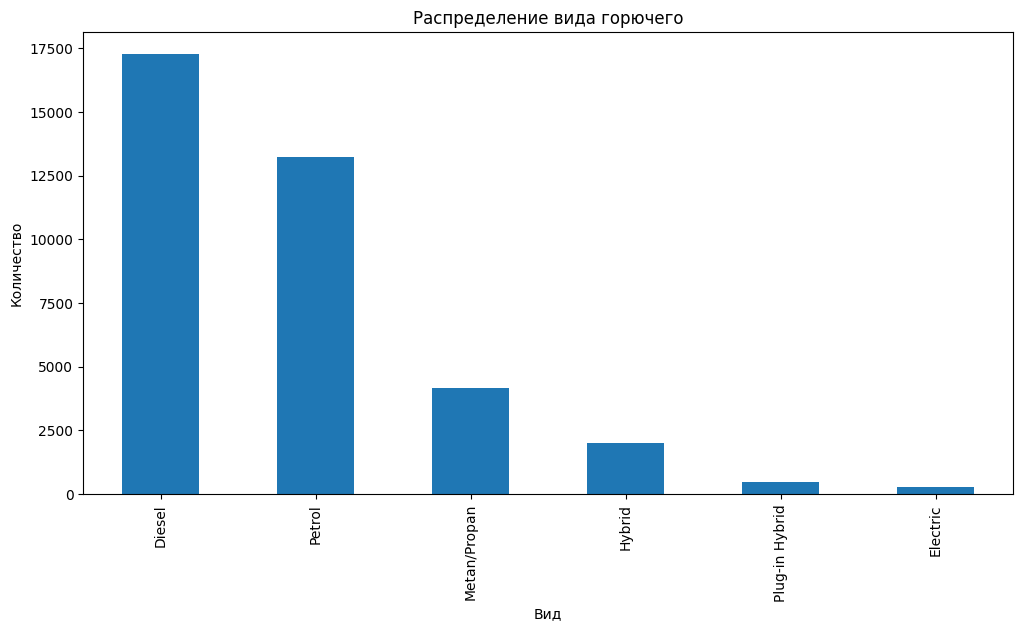

In [13]:
fuel_type_counts = cars_data['Fuel_type'].value_counts()
plt.figure(figsize=(12, 6))
fuel_type_counts.plot(kind='bar')
plt.title('Распределение вида горючего')
plt.xlabel('Вид')
plt.ylabel('Количество')
plt.xticks(rotation=90)
plt.show()

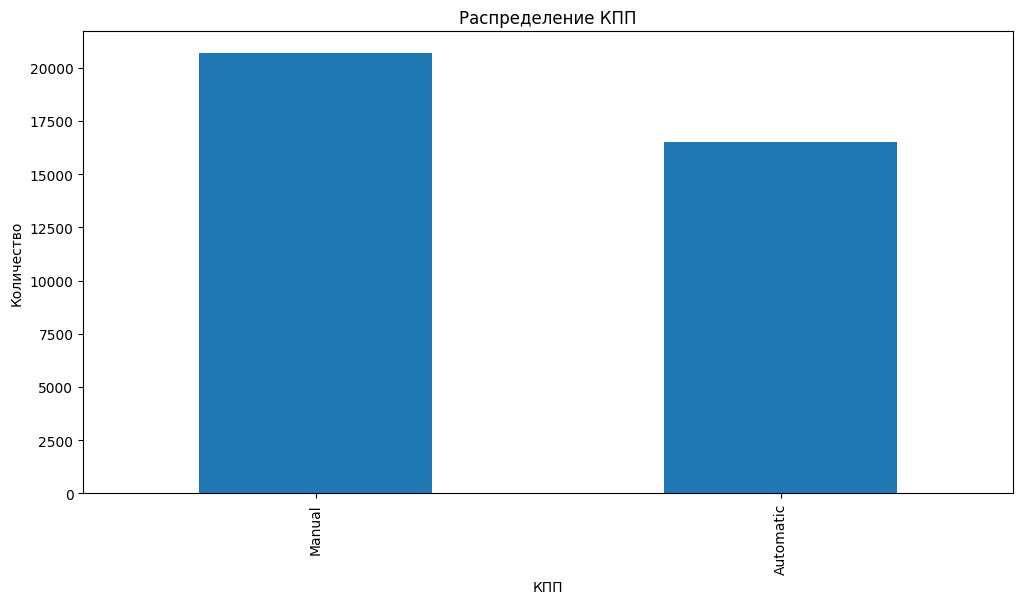

In [14]:
transmission_counts = cars_data['Transmission'].value_counts()
plt.figure(figsize=(12, 6))
transmission_counts.plot(kind='bar')
plt.title('Распределение КПП')
plt.xlabel('КПП')
plt.ylabel('Количество')
plt.xticks(rotation=90)
plt.show()

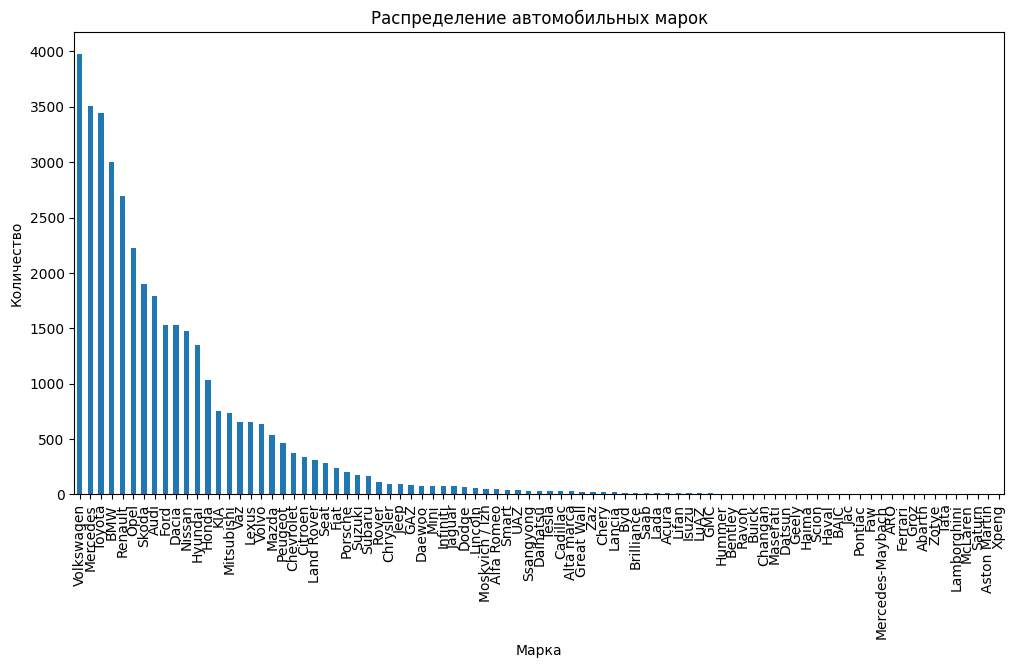

In [15]:
make_counts = cars_data['Make'].value_counts()
plt.figure(figsize=(12, 6))
make_counts.plot(kind='bar')
plt.title('Распределение автомобильных марок')
plt.xlabel('Марка')
plt.ylabel('Количество')
plt.xticks(rotation=90)
plt.show()

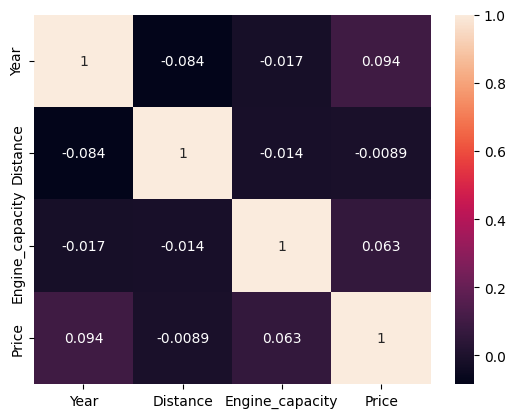

In [16]:
df_num = cars_data.select_dtypes(include=np.number)
df_corr = df_num.corr()
sns.heatmap(df_corr, annot=True);

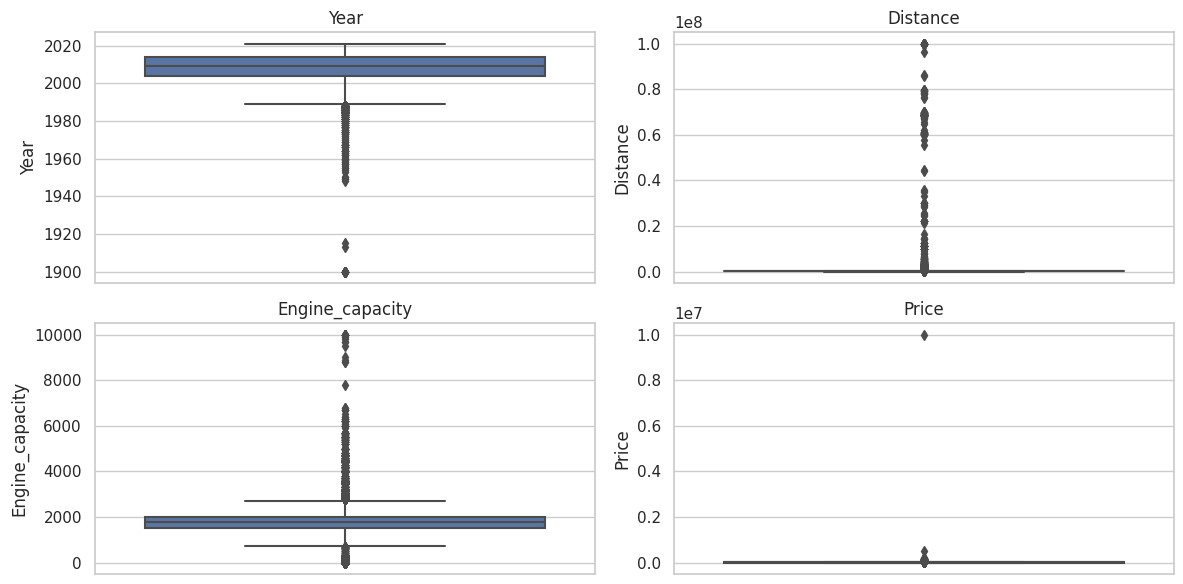

In [17]:
plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")

for i, column in enumerate(df_num.columns):
    plt.subplot(2, 2, i + 1)
    sns.boxplot(data=df_num, y=column)
    plt.title(column)

plt.tight_layout()
plt.show()

In [18]:
for column in df_num.columns:
    Q1 = cars_data[column].quantile(0.25)
    Q3 = cars_data[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    cars_data[column] = cars_data[column].apply(lambda x: x if (x >= lower_bound and x <= upper_bound) else cars_data[column].median())

In [19]:
cars_data.shape

(37418, 9)

# NEXT STEP

In [20]:
cars_data['Model'] = cars_data['Model'].fillna("Unknown")
cars_data['Year'] = cars_data['Year'].fillna(cars_data['Year'].median())
cars_data['Style'] = cars_data['Style'].fillna("Unknown")
cars_data['Distance'] = cars_data['Distance'].fillna(cars_data['Distance'].median())
cars_data['Transmission'] = cars_data['Transmission'].fillna("Unknown")

In [21]:
cars_data['Year'] = cars_data['Year'].astype(int)
cars_data['Engine_capacity'] = cars_data['Engine_capacity'].astype(int)
cars_data['Distance'] = cars_data['Distance'].astype(int)
cars_data['Price'] = cars_data['Price'].astype(int)

In [22]:
current_year = datetime.datetime.now().year
cars_data["Age"] = current_year - cars_data["Year"]

In [23]:
cars_data.isna().sum()

Make               0
Model              0
Year               0
Style              0
Distance           0
Engine_capacity    0
Fuel_type          0
Transmission       0
Price              0
Age                0
dtype: int64

In [24]:
cars_data.head()

,Make,Model,Year,Style,Distance,Engine_capacity,Fuel_type,Transmission,Price,Age
0,Toyota,Prius,2011,Hatchback,195000,1800,Hybrid,Automatic,7750,12
1,Renault,Grand Scenic,2014,Universal,135000,1500,Diesel,Manual,8550,9
2,Volkswagen,Golf,1998,Hatchback,1,1400,Petrol,Manual,2200,25
3,Renault,Laguna,2012,Universal,110000,1500,Diesel,Manual,6550,11
4,Opel,Astra,2006,Universal,200000,1600,Metan/Propan,Manual,4100,17


In [25]:
categorical_cols = ['Make', 'Model', 'Style', 'Fuel_type', 'Transmission']

In [26]:
def one_hot_encode_feature(X, feature_name):
    encoder = OneHotEncoder()
    matrix = encoder.fit_transform(X[[feature_name]]).toarray()
    feature_names = encoder.get_feature_names_out([feature_name])
    encoded_df = pd.DataFrame(matrix, columns=feature_names)
    return pd.concat([X, encoded_df], axis=1)

def featureencoder(X):
    categorical_features = ['Make', 'Model', 'Style', 'Fuel_type', 'Transmission']
    for feature in categorical_features:
        X = one_hot_encode_feature(X, feature)
    X.drop(categorical_features, axis=1, inplace=True)
    return X

In [27]:
cars_data = featureencoder(cars_data)

In [28]:
cars_data.shape

(37418, 944)

In [29]:
X = cars_data.drop("Price", axis=1)
y = cars_data['Price']

In [30]:
bestfeatures = SelectKBest(score_func = chi2, k = 'all')
fit = bestfeatures.fit(X, y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

featureScores = pd.concat([dfcolumns, dfscores], axis = 1)
featureScores.columns = ['Specs', 'Score']
print(featureScores.nlargest(10, 'Score'))

                     Specs         Score
1                 Distance  2.491319e+08
2          Engine_capacity  3.332806e+05
3                      Age  7.073790e+04
364              Model_D20  3.741700e+04
605        Model_NF Sonata  2.500730e+04
651            Model_Pikap  2.324347e+04
637            Model_Palio  2.244880e+04
217            Model_Albea  1.896685e+04
738        Model_SC Series  1.890189e+04
60   Make_Mercedes-Maybach  1.875155e+04


In [31]:
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)
# y = y.to_numpy()

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=17)

In [33]:
def fitting(model_list, X_train, X_test, y_train, y_test):
    metrics_model = dict()
    name_metrics = ["R2", "MSE", "RMSE", "MAE", "MAPE"]
    alpha_coef = dict()
    for model in model_list:
        metrics = []
        clf = model.fit(X_train, y_train)
        predicted = clf.predict(X_test)

        metrics = [r2_score(y_test, predicted),
                    mean_squared_error(y_test, predicted),
                    np.sqrt(mean_squared_error(y_test, predicted)),
                    mean_absolute_error(y_test, predicted),
                    mean_absolute_percentage_error(y_test, predicted)
        ]

        try:
          alpha_coef[model.__class__.__name__] = clf.alpha_

        except:
          alpha_coef[model.__class__.__name__] = None

        metrics_model[model.__class__.__name__] = dict(zip(name_metrics, metrics))

    return (metrics_model, alpha_coef)

In [34]:
models = [LassoCV(alphas=[0.001, 0.01, 0.1, 1.0, 10.0], cv=5),
          RidgeCV(alphas=[0.001, 0.01, 0.1, 1.0, 10.0], cv=5),
          LinearRegression(),
          Ridge(10.0),
          Lasso(1.0)]

In [35]:
info_models, alpha = fitting(models, X_train, X_test,y_train, y_test)

Результат обучения без нормирования данных

In [36]:
pprint(info_models)

{'Lasso': {'MAE': 2310.5603500826237,
           'MAPE': 0.6357768620820987,
           'MSE': 11494521.57573095,
           'R2': 0.577240135464197,
           'RMSE': 3390.3571457489475},
 'LassoCV': {'MAE': 2243.657321350178,
             'MAPE': 0.6524563399231804,
             'MSE': 11244702.908110352,
             'R2': 0.5864282783012842,
             'RMSE': 3353.312229439775},
 'LinearRegression': {'MAE': 2245.4002672855263,
                      'MAPE': 0.6424757531302584,
                      'MSE': 11357853.884498982,
                      'R2': 0.582266670431397,
                      'RMSE': 3370.141522918434},
 'Ridge': {'MAE': 2279.219706250605,
           'MAPE': 0.647652972453561,
           'MSE': 11304110.679728454,
           'R2': 0.5842433051106932,
           'RMSE': 3362.1586339327378},
 'RidgeCV': {'MAE': 2241.2226499896906,
             'MAPE': 0.6473641347151777,
             'MSE': 11199665.06765962,
             'R2': 0.5880847362236511,
             'RM

In [37]:
alpha

{'LassoCV': 0.1,
 'RidgeCV': 1.0,
 'LinearRegression': None,
 'Ridge': None,
 'Lasso': None}

In [ ]:
# poly = PolynomialFeatures(degree=2)

# # Добавление полиномиальной регрессии

# X_train_poly = poly.fit_transform(X_train)
# X_test_poly = poly.fit_transfrom(X_test)


In [39]:

# info_models, alpha = fitting(models, X_train_poly, X_test_poly, y_train, y_test)

In [40]:


# # Создание пайплайна
# regression_pipeline = Pipeline([
#     ('poly', PolynomialFeatures(degree=2)),
#     ('model', Lasso(alpha=1.0))  # Здесь можете выбрать любую модель, включая Ridge
# ])

# # Обучение и оценка пайплайна
# regression_pipeline.fit(X_train, y_train)
# predicted = regression_pipeline.predict(X_test)
# # Вычисление метрик
# r2 = r2_score(y_test, predicted)
# mse = mean_squared_error(y_test, predicted)
# rmse = np.sqrt(mse)
# mae = mean_absolute_error(y_test, predicted)
